Demand Forecaster from https://www.kaggle.com/c/demand-forecasting-kernels-only

In [46]:
## Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import OneHotEncoder

import torch as torch
import torch.nn as nn

In [2]:
## Import data

path_in = './data/'
train_cols = ['date', 'store', 'item', 'sales']
train_dtypes = {'date': 'str', 'store': 'int', 'item': 'int', 'sales': 'int'}
parse_dates = ['date']

test_cols = ['date', 'store', 'item']
test_dtypes = {'date': 'str', 'store': 'int', 'item': 'int'}


train = pd.read_csv(path_in + 'train.csv', dtype = train_dtypes, parse_dates = parse_dates)
test = pd.read_csv(path_in + 'test.csv', dtype = test_dtypes, parse_dates = parse_dates)

In [3]:
train.sample(10)

,date,store,item,sales
265166,2014-02-01,6,15,55
682926,2013-01-03,5,38,45
487634,2013-04-03,8,27,23
327777,2015-07-13,10,18,78
137224,2013-10-02,6,8,44
816838,2014-09-09,8,45,108
736085,2013-07-27,4,41,28
264365,2016-11-22,5,15,74
30066,2015-05-01,7,2,51
792857,2014-01-09,5,44,13


So there are 10 stores with 50 different products. The sales for each item range between 0 and 231, but they are mainly around the 30-70 range. There is five years worth of sales data (2013-2017) to train on and the goal is the predict the sales for the next 3 months.

In [4]:
sample = train.loc[train['store'] == 5].loc[train['item'] == 1]

In [5]:
sample

,date,store,item,sales
7304,2013-01-01,5,1,11
7305,2013-01-02,5,1,9
7306,2013-01-03,5,1,12
7307,2013-01-04,5,1,8
7308,2013-01-05,5,1,13
...,...,...,...,...
9125,2017-12-27,5,1,15
9126,2017-12-28,5,1,13
9127,2017-12-29,5,1,18
9128,2017-12-30,5,1,19


## Preprocessing
Here we create a windowed dataset to preprocess the data

In [6]:
# Include other date information to be processed
sample['day_of_week'] = sample['date'].dt.dayofweek
sample['month'] = sample['date'].dt.month
sample['year'] = sample['date'].dt.year - 2013 # Subtract earliest year to help normalize this information

In [11]:
def create_data_windows(df, width):
    """
    Function: Takes in the DataFrame, df, and splits it into rolling windows of size width to be used in a neural network.
    It outputs a dataframe and a target dataframe, which is the sales number to be predicted.
    Inputs: df - dataframe with columns [date, store, item, sales]
            width - the with of the window including the last sales data which will be the target
    Outputs: df_windowed - dataframe with the day of the week of the last day of the window, the store, and item numbers
                            along with the windowed sales data
             df_target - dataframe that contains the target date and target sales
    """

    # Initalize output datasets
    windowed_data = np.empty([len(df)-width+1, width+4])
    df = df.reset_index(drop = True)
    
    # Create windows. E.g. [1, 2, 3, 4, 5, 6, 7] -> [[1,2,3,4], [2,3,4,5], [3,4,5,6]]
    # Also creates targets which would be [[5], [6], [7]] in the above case
    for i in range(len(df)-width+1):
        row = list(df.iloc[i:i+width-1]['sales'])
        row_info = [df.loc[i,'day_of_week'],df.loc[i,'month'], df.loc[i,'year'], 
                    df.loc[i, 'store'], df.loc[i, 'item']]
        row = row_info + row
        windowed_data[i,:] = row
        
    # Create a DataFrame to contain the windowed data
    windowed_columns = ['day_of_week', 'month','year','store', 'item'] + list(map(str,(range(1,width))))
    
    df_windowed = pd.DataFrame(data = windowed_data, 
                               columns = windowed_columns,
                               dtype = 'int')
    
    # Create target dataset
    df_target = pd.DataFrame(data = df.loc[width-1::, ['date', 'sales']]).reset_index(drop = True)
        
    return df_windowed, df_target

In [12]:
window_size = 30
df, df_target = create_data_windows(sample, window_size)

In [13]:
df

,day_of_week,month,year,store,item,1,2,3,4,5,...,20,21,22,23,24,25,26,27,28,29
0,1,1,0,5,1,11,9,12,8,13,...,6,6,8,11,8,7,7,11,8,12
1,2,1,0,5,1,9,12,8,13,15,...,6,8,11,8,7,7,11,8,12,8
2,3,1,0,5,1,12,8,13,15,6,...,8,11,8,7,7,11,8,12,8,6
3,4,1,0,5,1,8,13,15,6,11,...,11,8,7,7,11,8,12,8,6,6
4,5,1,0,5,1,13,15,6,11,13,...,8,7,7,11,8,12,8,6,6,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1792,1,11,4,5,1,16,23,27,9,20,...,11,4,16,13,10,14,22,14,17,12
1793,2,11,4,5,1,23,27,9,20,14,...,4,16,13,10,14,22,14,17,12,15
1794,3,11,4,5,1,27,9,20,14,9,...,16,13,10,14,22,14,17,12,15,13
1795,4,12,4,5,1,9,20,14,9,9,...,13,10,14,22,14,17,12,15,13,18


In [14]:
df_target

,date,sales
0,2013-01-30,8
1,2013-01-31,6
2,2013-02-01,6
3,2013-02-02,20
4,2013-02-03,13
...,...,...
1792,2017-12-27,15
1793,2017-12-28,13
1794,2017-12-29,18
1795,2017-12-30,19


In [15]:
# Train-test split
sample_train_df, sample_train_target = df.iloc[:-365], df_target.iloc[:-365]
sample_val_df, sample_val_target = df.iloc[-365::], df_target.iloc[-365::]

In [16]:
sample_train_df

,day_of_week,month,year,store,item,1,2,3,4,5,...,20,21,22,23,24,25,26,27,28,29
0,1,1,0,5,1,11,9,12,8,13,...,6,6,8,11,8,7,7,11,8,12
1,2,1,0,5,1,9,12,8,13,15,...,6,8,11,8,7,7,11,8,12,8
2,3,1,0,5,1,12,8,13,15,6,...,8,11,8,7,7,11,8,12,8,6
3,4,1,0,5,1,8,13,15,6,11,...,11,8,7,7,11,8,12,8,6,6
4,5,1,0,5,1,13,15,6,11,13,...,8,7,7,11,8,12,8,6,6,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,0,11,3,5,1,22,15,18,6,19,...,21,15,10,13,14,7,16,16,15,10
1428,1,11,3,5,1,15,18,6,19,15,...,15,10,13,14,7,16,16,15,10,9
1429,2,11,3,5,1,18,6,19,15,14,...,10,13,14,7,16,16,15,10,9,6
1430,3,12,3,5,1,6,19,15,14,21,...,13,14,7,16,16,15,10,9,6,23


In [17]:
sample_train_target

,date,sales
0,2013-01-30,8
1,2013-01-31,6
2,2013-02-01,6
3,2013-02-02,20
4,2013-02-03,13
...,...,...
1427,2016-12-27,9
1428,2016-12-28,6
1429,2016-12-29,23
1430,2016-12-30,16


Turn dataframes into tensors to prepare them to be fed into neural network in pytorch

In [18]:
training_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(np.array(sample_train_df)), torch.FloatTensor(np.array(sample_train_target['sales'])))
validation_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(np.array(sample_val_df)), torch.FloatTensor(np.array(sample_val_target['sales'])))

# Neural Network

Initalize Neural Network

In [23]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias,0)
        
class Net(nn.Module):
    def __init__(self, split_pos, window_length, n_hidden_1, n_hidden_2, D_out, p=0.0):
        super().__init__()
        
        # Subtract 1 because that's the target length
        self.window_length = window_length - 1
        self.split_pos = split_pos
        
        self.lstm1 = nn.LSTM(1, n_hidden_1, bidirectional = False, batch_first = True)
        
        self.fc1 = nn.Linear(n_hidden_1 + split_pos, n_hidden_2)
        # self.drop1 = nn.Dropout(p=p)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_2, D_out)
        self.out_act = nn.ReLU()
        
    def forward(self, x):
        # Split input tensor. x_seq will be fed into the lstm.
        x_info, x_seq = x[:,:self.split_pos], x[:,self.split_pos:]
        
        # LSTM layer
        x_seq = torch.unsqueeze(x_seq, 2)
        lstm_out, (h, c) = self.lstm1(x_seq)
        
        # Combine the extra info to the lstm results using the output of the last lstm neuron
        lstm_output = torch.squeeze(lstm_out[:,1,:])
        
        combined_out = torch.cat([lstm_output, x_info], 1)
        
        # Fully connected layer
        fc1_out = self.fc1(combined_out)
        fc1_out = self.relu1(fc1_out)
        
        # Output layer
        y = self.out_act(self.fc2(fc1_out))
        
        # Squeeze to remove extra dimensions of size 1
        return torch.squeeze(y)

In [24]:
def train_model(data_set, model, criterion, train_loader, validation_loader, optimizer, epochs=10):
    model.train()
    loss_accuracy = {'training_loss':[], 'validation_loss':[],'validation_accuracy':[], 'validation_precision':[], 'validation_recall':[]}
    
    for epoch in range(epochs):
        #clear_output(wait=True)
        print("Epoch {} / {}\n=============".format(epoch+1, epochs))
            

        
        train_correct = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            ## Forward pass
            yhat = model(x)
            ## Compute loss
            train_loss = criterion(yhat, y)
            ## Compute gradient in backward pass
            train_loss.backward()
            ## Update weights
            optimizer.step()
            
            yhat = np.where(yhat.detach().numpy() > 0.5, 1, 0)
            train_correct += (yhat == y.numpy()).sum()
            
            loss_accuracy['training_loss'].append(train_loss.item())
         
        ## Compute validation accuracy
        model.eval()
        correct = 0
        for x, y in validation_loader:
            yhat = net(x)
            val_loss = criterion(yhat, y)
            yhat = np.where(yhat.detach().numpy() > 0.5, 1, 0)
            correct = (yhat == y.detach().numpy()).sum()                        
            accuracy = 100 * (correct / validation_loader.batch_size)
        
        loss_accuracy['validation_loss'].append(val_loss.item())
        loss_accuracy['validation_accuracy'].append(accuracy)
        
        ## Print training loss and accuracy, and validation accuracy
        train_acc = 100 * train_correct / len(train_loader.dataset)
        loss_accuracy['training_loss'].append(train_acc)
        print("Training loss: {} | Training accuracy: {:.2f}%\nValidation loss: {:.2f} | Validation accuracy: {:.2f}%".format(
                     train_loss.item(), train_acc, val_loss.item(), accuracy))
        
        model.train()
        
        ## Add precision and recall
        
    print("Training complete!")
                
    return loss_accuracy

In [25]:
epochs = 10
learning_rate = 0.0005

## Network dimensions
split_pos = 5
n_hidden_1 = 32
n_hidden_2 = 32
D_out = 1
batch_size = 64
reg_lambda = 0
momentum_coef = 0.9
dropout_percent = 0.0

## Load data
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset), shuffle=False)

## Initialize model
net = Net(split_pos, window_size, n_hidden_1, n_hidden_2, D_out, p = dropout_percent)
net.apply(weights_init)


optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = reg_lambda)
criterion = nn.MSELoss()

In [27]:
epochs = 10
## Train the model
loss_accuracy = train_model(training_dataset, net, criterion, train_loader, validation_loader, optimizer, epochs=epochs)

Epoch 1 / 10
Training loss: 41.07759475708008 | Training accuracy: 0.00%
Validation loss: 36.29 | Validation accuracy: 0.00%
Epoch 2 / 10
Training loss: 41.280517578125 | Training accuracy: 0.00%
Validation loss: 35.89 | Validation accuracy: 0.00%
Epoch 3 / 10
Training loss: 19.787424087524414 | Training accuracy: 0.00%
Validation loss: 35.14 | Validation accuracy: 0.00%
Epoch 4 / 10
Training loss: 32.706172943115234 | Training accuracy: 0.00%
Validation loss: 34.50 | Validation accuracy: 0.00%
Epoch 5 / 10
Training loss: 32.55009078979492 | Training accuracy: 0.00%
Validation loss: 34.13 | Validation accuracy: 0.00%
Epoch 6 / 10
Training loss: 21.70465850830078 | Training accuracy: 0.00%
Validation loss: 33.37 | Validation accuracy: 0.00%
Epoch 7 / 10
Training loss: 35.99653625488281 | Training accuracy: 0.00%
Validation loss: 33.07 | Validation accuracy: 0.00%
Epoch 8 / 10
Training loss: 21.31110382080078 | Training accuracy: 0.00%
Validation loss: 32.31 | Validation accuracy: 0.00%


Text(0, 0.5, 'Accuracy [%]')

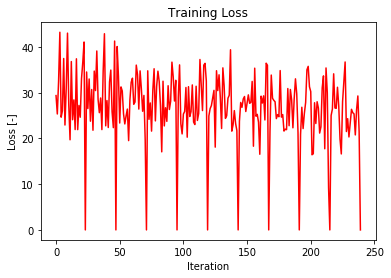

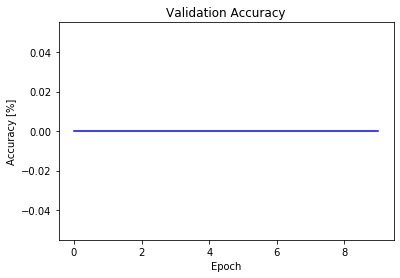

In [28]:
## Plots
fig = plt.figure(1)
plt.plot(loss_accuracy['training_loss'], color="red")
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss [-]")

fig = plt.figure(2)
plt.plot(loss_accuracy['validation_accuracy'], color="blue")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")

In [43]:
sample.loc[((sample['date'] > '2013-01-20') & (sample['date'] < '2013-02-20'))]

,date,store,item,sales,day_of_week,month,year
7324,2013-01-21,5,1,6,0,1,0
7325,2013-01-22,5,1,8,1,1,0
7326,2013-01-23,5,1,11,2,1,0
7327,2013-01-24,5,1,8,3,1,0
7328,2013-01-25,5,1,7,4,1,0
7329,2013-01-26,5,1,7,5,1,0
7330,2013-01-27,5,1,11,6,1,0
7331,2013-01-28,5,1,8,0,1,0
7332,2013-01-29,5,1,12,1,1,0
7333,2013-01-30,5,1,8,2,1,0


In [47]:
# sample['date'] + datetime.timedelta(days = 1)

7304   2013-01-02
7305   2013-01-03
7306   2013-01-04
7307   2013-01-05
7308   2013-01-06
          ...    
9125   2017-12-28
9126   2017-12-29
9127   2017-12-30
9128   2017-12-31
9129   2018-01-01
Name: date, Length: 1826, dtype: datetime64[ns]